# Задача идентификации пользователя по посещенным веб-страницам

### 1. Постановка задачи

В интернете каждый пользователь ведет себя по-разному. Некоторые пользователи в начале дня посещают информационные и новостные ресурсы, другие сразу принимаются за работу и только вечером посещают развлекательные ресурсы, третьи используют интернет в основном для общения и обмена медиа-информацией.

Даже при работе с одним ресурсом, поведение пользователей довольно сильно отличается. Таким образом кажется возможным по поведению пользователя в сети определять типично ли оно для определенного пользователя или нет.

Задача представляет особый интерес в рамках доступа к песональным данным, банковским счетам, рабочим документам. Отслеживая поведение пользователя в сети или на конкретном ресурсе, и обнаружив отклонение от тичиного, владельцы ресурса получают возможность связаться с пользователем для уточнения, или просто заставить пользователя ответить на контрольные вопросы, чтобы убедиться, что именно этот пользователь использует ресурс.

<b>Цель: По цепочке посещенных ресурсов (веб-страниц) как можно точнее отвечать на вопрос принадлежит ли эта цепочка отслеживаемому пользователю или нет.</b>

### 2. Исходные данные

Для анализа будем использовать данные, полученные с прокси-серверов Университета Блеза Паскаля. Они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

<center><i>timestamp, посещенный веб-сайт</i></center>

Для анализа нам доступно приблизительно ~ 1500 файлов с сессиями разных пользователей.

### 3. Первичный анализ данных и предобработка

In [1]:
from glob import glob
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

from scipy.sparse import csr_matrix, hstack

from matplotlib import pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None

Посмотрим на содержимое файлов:

In [2]:
PATH_TO_DATA = '/Users/ngorovoy/Python/Coursera/Course6/10data/'

In [3]:
!head -5 $PATH_TO_DATA/user0006.csv

timestamp,site
2013-11-15 08:01:09,www.google.fr
2013-11-15 08:01:10,www.google.fr
2013-11-15 08:01:11,apis.google.com
2013-11-15 08:01:12,www.google.com


Для подготовки к анализу данных введем понятие сессии. <b>Сессией будем считать некоторый упорядоченный набор посещенных пользователем веб-страниц с указанием времени посещения</b>. При этом не будем пока накладывать ограничения на длину сессии как по количеству посещений так и по длительности. В будущем попытаемся использовать эти ограничения как дополнительные параметры для обучения.

Определим вспомогательные функции чтения данных из файлов:

In [4]:
# Возвращает идентификатор пользователя по пути до файла
def get_user_id_from_filename(filename):
    m = re.search('^user(\d+).csv$', os.path.split(filename)[-1])
    return int(m.group(1))

# Читает файл в dataframe
def read_datafeame_from_file(filename):
    return pd.read_csv(filename)

# Возвращает список файлов заданной директории
def get_files_in_directory(directory, pattern = 'user*.csv'):
    return glob(os.path.join(directory, pattern))

Каждому сайту из выборки поставим в соответствие идентификатор. При этом идентификатор тем меньше, чем чаще сайт встречается в выборке. Словарь будет иметь вид: {id: (site, frequency}, ...}

In [5]:
# Строит словарь частот встречаемости сайтов
def build_sites_frequency(directory):
    sites_frequency = {}
    for filename in get_files_in_directory(directory):
        dataframe = read_datafeame_from_file(filename)
        for site in dataframe['site']:
            if not site in sites_frequency:
                sites_frequency[site] = 0
            sites_frequency[site] += 1
            
    frequency_list = [(k, v) for k, v in sites_frequency.iteritems()]
    sorted_frequency = sorted(frequency_list, key = lambda x: x[1], reverse = True)
    
    result = {}
    for idx, row in enumerate(sorted_frequency):
        result[row[0]] = (idx + 1, row[1])
    
    return result

In [21]:
frequency = build_sites_frequency(PATH_TO_DATA)

Определим функции, собирающие данные в сесcии

In [6]:
# Построение сессий пользователей по количеству сайтов в сессии
def build_sessions_by_size(directory, frequency, size = 10, offset = 10):
    rows = []
    
    for filename in get_files_in_directory(directory):
        user_id = get_user_id_from_filename(filename)
        dataframe = read_datafeame_from_file(filename)
        
        sites_row = []
        timestamps_row = []
        
        for _, row in dataframe.iterrows():
            sites_row.append(frequency[row['site']][0])
            timestamps_row.append(row['timestamp'])
            
            if len(sites_row) == size:
                row = sites_row + timestamps_row + [user_id]
                rows.append(row)

                sites_row = sites_row[size - (size - offset):]
                timestamps_row = timestamps_row[size - (size - offset):]
            
        while len(sites_row):
            fake_sites = sites_row + [0] * (size - len(sites_row))
            fake_timestamps = timestamps_row + [''] * (size - len(timestamps_row))
            row = fake_sites + fake_timestamps + [user_id]
            rows.append(row)
            
            sites_row = sites_row[size - (size - offset):]
            timestamps_row = timestamps_row[size - (size - offset):]
            
    site_columns = ['site_' + str(x) for x in range(1, size + 1)]
    timestamp_columns = ['timestamp_' + str(x) for x in range(1, size + 1)]
    columns = site_columns + timestamp_columns + ['user_id']
    
    return pd.DataFrame(data = rows, columns = columns)

In [7]:
# Построение сессий пользователей по продолжительности сессии
def build_sessions_by_timespan(directory, frequency, length = 30 * 60):
    rows = []
    max_length = 0
    for filename in get_files_in_directory(directory):
        user_id = get_user_id_from_filename(filename)
        dataframe = read_datafeame_from_file(filename)
        dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
        
        sites = []
        timestamps = []
        start_time = False
        for idx, row in dataframe.iterrows():
            if not start_time:
                start_time = row['timestamp']
                sites.append(frequency[row['site']][0])
                timestamps.append(row['timestamp'])
                continue
            
            current_time = row['timestamp']
            if (current_time - start_time).seconds > length:
                rows.append((sites, timestamps, user_id))
                if max_length < len(sites):
                    max_length = len(sites)
                sites = []
                timestamps = []
                start_time = current_time
                
            sites.append(frequency[row['site']][0])
            timestamps.append(row['timestamp'])
        
        rows.append((sites, timestamps, user_id))
        if max_length < len(sites):
            max_length = len(sites)
        
    data = []
    for row in rows:
        sites = row[0] + [0] * (max_length - len(row[0]))
        timestamps = row[1] + [''] * (max_length - len(row[1]))
        data.append(sites + timestamps + [row[2]])
    
    site_columns = ['site_' + str(x) for x in range(1, max_length + 1)]
    timestamp_columns = ['timestamp_' + str(x) for x in range(1, max_length + 1)]
    columns = site_columns + timestamp_columns + ['user_id']
    
    return pd.DataFrame(data = data, columns = columns)

Для дальнейшей работы построим два dataframe'a по-умолчанию: один с ограничением на длину сессии по количеству посещений ресурсов в ней, второй с ограничением длины сессии в 30 секунд.

In [22]:
sessions_length_10_10 = build_sessions_by_size(PATH_TO_DATA, frequency)
sessions_time_30 = build_sessions_by_timespan(PATH_TO_DATA, frequency, 30)

### 4. Первое решение задачи

Данные в подготовленном выше виде не подходят для обработки алгоритмами машинного обучения. Нам необходимо перевести данные в вид, понятный таким алгоритмам. Попробуем переработать посещенные пользователями сайты в Compressed Sparse Row matrix и уже на полученных данных выполнить первую классификацию.

In [8]:
# Возвращает размерность по количеству сайтов в dataframe
def get_sites_count(dataframe):
    result = 0
    for row_name in dataframe:
        m = re.search('^site_(\d+)$', row_name)
        if m and int(m.group(1)) > result:
            result = int(m.group(1))
    return result

In [9]:
# Возвращает Compressed Sparse Row matrix на основании переданного dataframe
def get_csr_matrix(dataframe):
    data = []
    row = []
    col = []

    for i, session in enumerate(dataframe):
        for site in session:
            site = int(site)
            if site == 0:
                continue

            data.append(1)
            row.append(i)
            col.append(site - 1)
    
    return csr_matrix((data, (row, col)))

Построим csr_matrix для данных на основании длины сессии

In [155]:
s_l_10_10_sites = sessions_length_10_10[['site_%d' % i for i in range(1, get_sites_count(sessions_length_10_10) + 1)]]
s_l_10_10_csr = get_csr_matrix(s_l_10_10_sites.values)

Теперь построим csr_matrix для данных на основании продолжительности сессии

In [156]:
s_t_30_sites = sessions_time_30[['site_%d' % i for i in range(1, get_sites_count(sessions_time_30) + 1)]]
s_t_30_csr = get_csr_matrix(s_t_30_sites.values)

Проверим, что при разрежении мы получили одинаковую размерность по количеству столбцов

In [157]:
'{} == {}'.format(s_l_10_10_csr.shape[1], s_t_30_csr.shape[1])

'4319 == 4319'

Создадим dataframe'ы с ответами:

In [158]:
y_l_10_10 = sessions_length_10_10['user_id']
y_t_30 = sessions_time_30['user_id']

Для анализа качества обучения будем использовать кросс-валидацию:

In [11]:
skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=17)

Разделим данные в выборках на train и test:

In [24]:
X_train_l_10_10, X_test_l_10_10, y_train_l_l0_10, y_test_l_10_10 = train_test_split(
    s_l_10_10_sites,
    y_l_10_10,
    test_size = 0.3, 
    random_state = 17,
    stratify = y_l_10_10
)

In [25]:
X_train_t_30, X_test_t_30, y_train_t_30, y_test_t_30 = train_test_split(
    s_t_30_sites,
    y_t_30,
    test_size = 0.3, 
    random_state = 17,
    stratify = y_t_30
)

Обучим несколько классификаторов на получившихся входных данных и проверим качество обучения:

In [10]:
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs = -1)

In [13]:
l_acc = cross_val_score(knn, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(knn, X_train_t_30, y_train_t_30, cv = skf).mean()

In [27]:
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.294365145575, t = 0.352637344466


In [11]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 17, oob_score = True, n_jobs = -1)

In [14]:
l_acc = cross_val_score(rfc, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(rfc, X_train_t_30, y_train_t_30, cv = skf).mean()

In [29]:
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.537933433743, t = 0.507755932047


In [12]:
lr = LogisticRegression(random_state = 17, n_jobs = -1)

In [15]:
l_acc = cross_val_score(lr, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(lr, X_train_t_30, y_train_t_30, cv = skf).mean()

In [31]:
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.22145894417, t = 0.198821116635


Проверим качество обучения на отложенной выборке:

In [32]:
knn.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.2880449317999465

In [33]:
rfc.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.56539181599358113

In [34]:
lr.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.22225193902112864

### 5. Переход к  tf-idf

Первоначальный подход к построению матрицы для решения показывает сколько раз пользователь в рамках одной сессии посетил каждый сайт. Данный подход не учитывает сессии других пользователей. Данного недостатка лишен подход построения обучающей выборки с помощью tf-idf. Попробуем применить этот подход к задаче:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [161]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=0, token_pattern=r"\b\w+\b", sublinear_tf=True)

In [162]:
texts_l_10_10 = [" ".join(['' if pd.isnull(site) else str(int(site)) for site in i[1]])  for i in s_l_10_10_sites.iterrows()]
tfidf_l_10_10 = tfidf.fit_transform(texts_l_10_10)

In [163]:
texts_t_30 = [" ".join(['' if pd.isnull(site) else str(int(site)) for site in i[1]])  for i in s_t_30_sites.iterrows()]
tfidf_t_30 = tfidf.fit_transform(texts_t_30)

In [39]:
X_train_l_10_10, X_test_l_10_10, y_train_l_l0_10, y_test_l_10_10 = train_test_split(
    tfidf_l_10_10,
    y_l_10_10,
    test_size = 0.3, 
    random_state = 17,
    stratify = y_l_10_10
)

In [40]:
X_train_t_30, X_test_t_30, y_train_t_30, y_test_t_30 = train_test_split(
    tfidf_t_30,
    y_t_30,
    test_size = 0.3, 
    random_state = 17,
    stratify = y_t_30
)

In [41]:
l_acc = cross_val_score(knn, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(knn, X_train_t_30, y_train_t_30, cv = skf).mean()

In [42]:
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.703117254644, t = 0.598089469607


In [43]:
l_acc = cross_val_score(rfc, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(rfc, X_train_t_30, y_train_t_30, cv = skf).mean()

In [44]:
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.804559135357, t = 0.699717536494


In [45]:
l_acc = cross_val_score(lr, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(lr, X_train_t_30, y_train_t_30, cv = skf).mean()

In [46]:
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.812812509806, t = 0.680958125265


In [47]:
knn.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.71783899438352505

In [48]:
rfc.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.82000534902380318

In [49]:
lr.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.83123829901043056

Качество всех моделей значительно улучшилось при применении tf-idf. Далее не будем использовать подход с разреженной матрицей, описанный ваше.

### 6. CountVectorizer

Попробуем добавить к нашим данным CountVectorizer и посмотреть как он повлияет на результат обучения.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [165]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=0, token_pattern=r"\b\w+\b")

In [166]:
cv_l_10_10 = cv.fit_transform(texts_l_10_10)

In [167]:
cv_t_30 = cv.fit_transform(texts_t_30)

Объединим полученные матрицы с tf-idf:

In [168]:
tfcv_l_10_10 = hstack([tfidf_l_10_10, cv_l_10_10], format = 'csr')
tfcv_t_30 = hstack([tfidf_t_30, cv_t_30], format = 'csr')

In [55]:
X_train_l_10_10, X_test_l_10_10, y_train_l_l0_10, y_test_l_10_10 = train_test_split(
    tfcv_l_10_10,
    y_l_10_10,
    test_size = 0.3, 
    random_state = 17,
    stratify = y_l_10_10
)

In [56]:
X_train_t_30, X_test_t_30, y_train_t_30, y_test_t_30 = train_test_split(
    tfcv_t_30,
    y_t_30,
    test_size = 0.3, 
    random_state = 17,
    stratify = y_t_30
)

In [57]:
l_acc = cross_val_score(knn, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(knn, X_train_t_30, y_train_t_30, cv = skf).mean()
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.651766584762, t = 0.466408508902


In [58]:
l_acc = cross_val_score(rfc, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(rfc, X_train_t_30, y_train_t_30, cv = skf).mean()
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.797111921339, t = 0.687566522673


In [59]:
l_acc = cross_val_score(lr, X_train_l_10_10, y_train_l_l0_10, cv = skf).mean()
t_acc = cross_val_score(lr, X_train_t_30, y_train_t_30, cv = skf).mean()
print('l = {}, t = {}'.format(l_acc, t_acc))

l = 0.82759506558, t = 0.704692144602


In [60]:
knn.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.688954265846483

In [61]:
rfc.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.81091200855843804

In [62]:
lr.fit(X_train_l_10_10, y_train_l_l0_10).score(X_test_l_10_10, y_test_l_10_10)

0.85557635731479009

В некоторых случаях CountVectorizer дает увеличение качества обучения. Будем использовать его в дальнейшем.

### 7. Добавление новых признаков

На данный момент для прогноза использовались только признаки посещенных сайтов. Попробуем добавить дополнительные признаки для того, чтобы повлиять на качество обучения моделей.

In [23]:
# Выедилим временные признаки и установим для них тип datetime
s_l_10_10_times = sessions_length_10_10[['timestamp_%d' % i for i in range(1, get_sites_count(sessions_length_10_10) + 1)]]
for column in s_l_10_10_times:
    s_l_10_10_times[column] = pd.to_datetime(s_l_10_10_times[column])

<b>Количество уникальных сайтов в сессии</b>

In [78]:
unique_sites = [len(list(set([0 if pd.isnull(site) else int(site) for site in i[1]]))) for i in s_l_10_10_sites.iterrows()]

<b>Количество сайтов из ТОП-10 в сессии</b>

In [24]:
def get_top_sites_count(dataframe, top = 10):
    result = []
    for idx, row in dataframe.iterrows():
        result.append(len(filter(lambda x: x <= top, row.values)))
    return result

In [ ]:
top_sites = get_top_sites_count(s_l_10_10_sites)

<b>Длина сессии в секундах</b>

In [25]:
def get_timespan(dataframe):
    result = []
    for idx, row in dataframe.iterrows():
        start = end = row[0]
        for timestamp in row:
            if pd.isnull(timestamp):
                break
            end = timestamp
        result.append((end-start).seconds)
    return result

In [ ]:
timespan = get_timespan(s_l_10_10_times)

<b>Час начала сессии</b>

In [26]:
def get_start_hour(dataframe):
    result = []
    for idx, row in dataframe.iterrows():
        result.append(row[0].hour)
    return result

In [ ]:
start_hour = get_start_hour(s_l_10_10_times)

<b>День недели начала сесии</b>

In [27]:
def get_day_of_week(dataframe):
    result = []
    for idx, row in dataframe.iterrows():
        result.append(row[0].dayofweek)
    return result

In [ ]:
day_of_week = get_day_of_week(s_l_10_10_times)

<b>Проанализируем полученные признаки</b>

In [121]:
features = pd.DataFrame({
    'unique_sites': unique_sites,
    'top_sites': top_sites,
    'timespan': timespan,
    'start_hour': start_hour,
    'day_of_week': day_of_week,
    'user_id': list(y_l_10_10.values)
})

Убедимся, что все признаки заполнены и в них нет пропусков

In [117]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12463 entries, 0 to 12462
Data columns (total 6 columns):
day_of_week     12463 non-null int64
start_hour      12463 non-null int64
timespan        12463 non-null int64
top_sites       12463 non-null int64
unique_sites    12463 non-null int64
user_id         12463 non-null int64
dtypes: int64(6)
memory usage: 584.3 KB


Построим график взаимной корреляции признаков

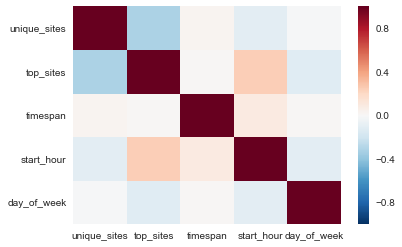

In [123]:
corr_matrix = features[['unique_sites', 'top_sites', 'timespan', 'start_hour', 'day_of_week']].corr()
sns.heatmap(corr_matrix);

Из графика видно, что никакие признаки не коррелируют между собой, поэтому для дальнейшего анализа оставим их все.

Построим гистограммы распределения признаков для каждого пользователя:

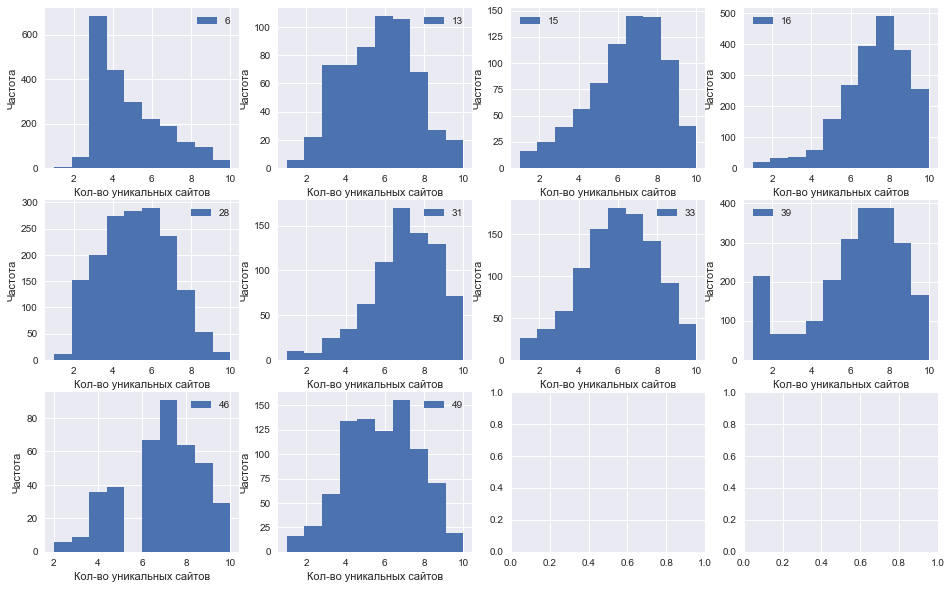

In [127]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features, 'user_id')): 
    ax = axes[idx / 4, idx % 4]
    ax.hist(sub_df['unique_sites'])
    ax.legend([user])
    ax.set_xlabel(u'Кол-во уникальных сайтов')
    ax.set_ylabel(u'Частота')

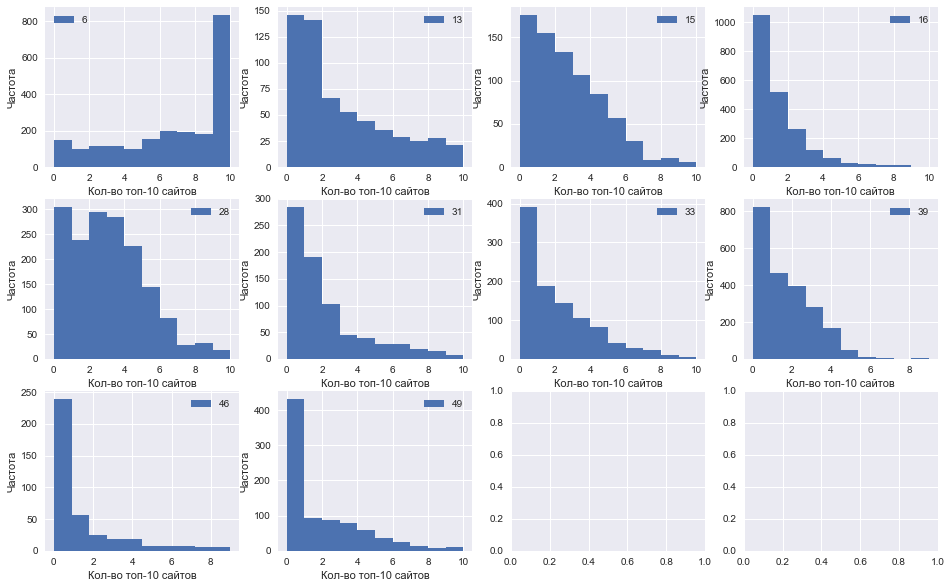

In [131]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features, 'user_id')): 
    ax = axes[idx / 4, idx % 4]
    ax.hist(sub_df['top_sites'])
    ax.legend([user])
    ax.set_xlabel(u'Кол-во топ-10 сайтов')
    ax.set_ylabel(u'Частота')

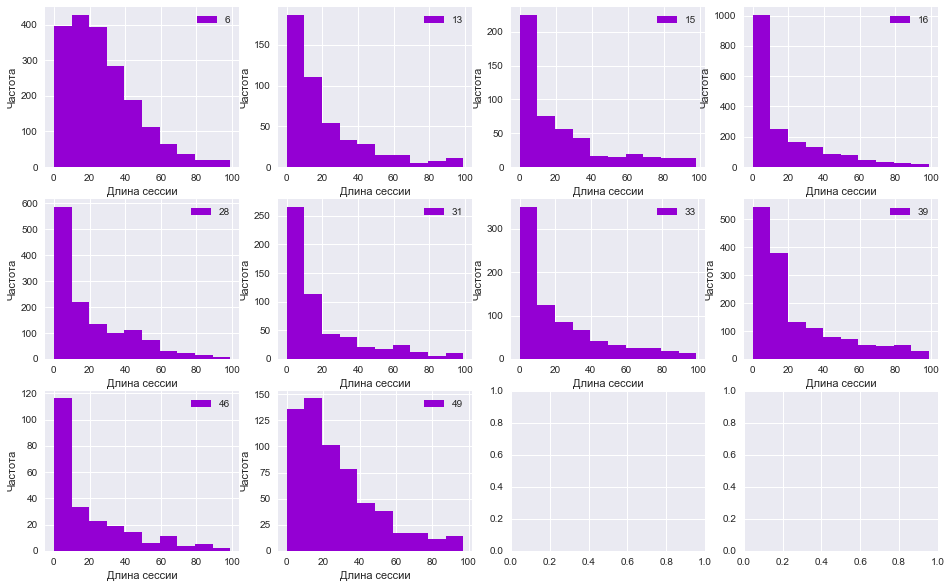

In [132]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features, 'user_id')): 
    ax = axes[idx / 4, idx % 4]
    ax.hist(sub_df[sub_df.timespan < 100].timespan, color = 'darkviolet')
    ax.legend([user])
    ax.set_xlabel(u'Длина сессии')
    ax.set_ylabel(u'Частота')

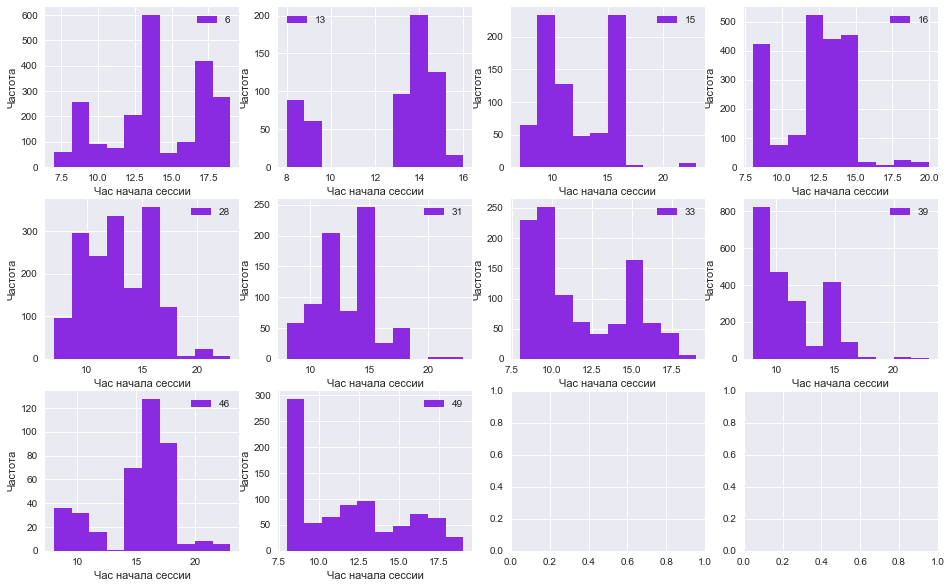

In [133]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features, 'user_id')): 
    ax = axes[idx / 4, idx % 4]
    ax.hist(sub_df['start_hour'], color = 'blueviolet')
    ax.legend([user])
    ax.set_xlabel(u'Час начала сессии')
    ax.set_ylabel(u'Частота')

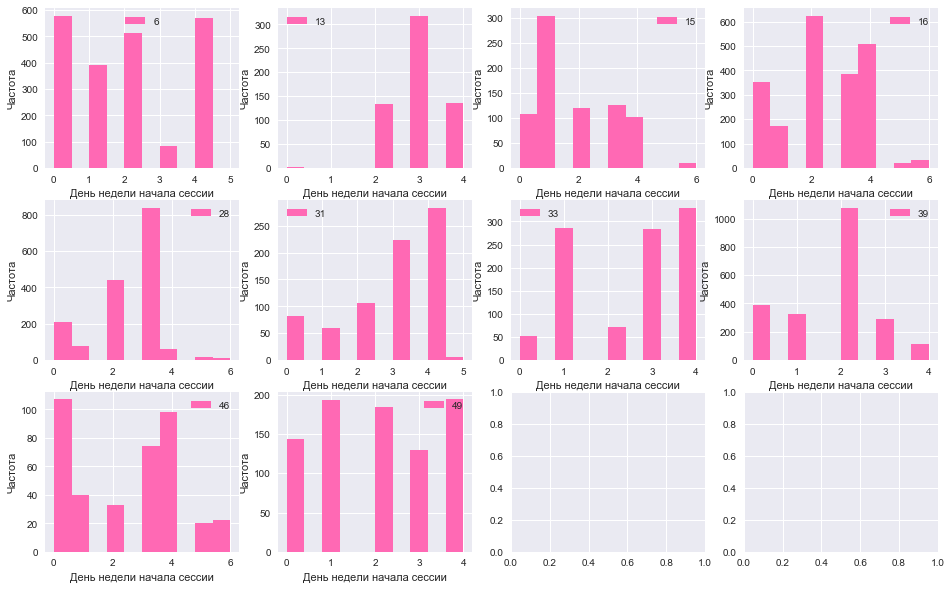

In [134]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features, 'user_id')): 
    ax = axes[idx / 4, idx % 4]
    ax.hist(sub_df['day_of_week'], color = 'hotpink')
    ax.legend([user])
    ax.set_xlabel(u'День недели начала сессии')
    ax.set_ylabel(u'Частота')

Из графиков видно, что признаки "Количество уникальных сайтов" и "Количество сайтов из топ-10" хотя и не сильно отличаются для разных пользователей, но для некоторых пользователей являются достаточно индивидуальными. Такие признаки помогут лучше отделать пользователей от всех остальных.

Признак "Продолжительность сессии в секундах" имеет примерно одинаковое распределение для всех пользователей.

Признаки "Час начала сессии" и "День недели начала сессии" распределены по-разному для пользователей и, вероятно, улучшат качество обучения.

### 8. Обучение моделей

Определим две функции, которые будут отдавать полный набор признаков, готовый для обучения.

In [28]:
# Строит признаки по длине сессии
def build_features_by_size(directory, frequency, size = 10, offset = 10):
    sessions = build_sessions_by_size(directory, frequency, size, offset)
    
    #sites, timestamps
    sites = sessions[['site_%d' % i for i in range(1, get_sites_count(sessions) + 1)]]
    timestamps = sessions[['timestamp_%d' % i for i in range(1, get_sites_count(sessions) + 1)]]
    for column in timestamps:
        timestamps[column] = pd.to_datetime(timestamps[column])
    
    #tf-idf
    tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=0, token_pattern=r"\b\w+\b", sublinear_tf=True)
    texts = [" ".join(['' if pd.isnull(site) else str(int(site)) for site in i[1]])  for i in sites.iterrows()]
    tfidf_features = tfidf.fit_transform(texts)
    
    #ConuntVectorizer
    cv = CountVectorizer(ngram_range=(1, 2), min_df=0, token_pattern=r"\b\w+\b")
    cv_features = cv.fit_transform(texts)
    
    #additional features
    unique_sites = [len(list(set([0 if pd.isnull(site) else int(site) for site in i[1]]))) for i in sites.iterrows()]
    top_sites = get_top_sites_count(sites)
    timespan = get_timespan(timestamps)
    start_hour = get_start_hour(timestamps)
    day_of_week = get_day_of_week(timestamps)
    
    return hstack([
        tfidf_features,
        cv_features,
        np.array(unique_sites).reshape(len(unique_sites),1),
        np.array(top_sites).reshape(len(top_sites), 1),
        np.array(timespan).reshape(len(timespan), 1),
        np.array(start_hour).reshape(len(start_hour), 1),
        np.array(day_of_week).reshape(len(day_of_week), 1),
        np.array(list(sessions['user_id'].values)).reshape(len(unique_sites), 1)
    ], format='csr')

In [29]:
# Строит признаки по продолжительности сессии
def build_features_by_timespan(directory, frequency, length = 30 * 60):
    sessions = build_sessions_by_timespan(directory, frequency, length)
    
    #sites, timestamps
    sites = sessions[['site_%d' % i for i in range(1, get_sites_count(sessions) + 1)]]
    timestamps = sessions[['timestamp_%d' % i for i in range(1, get_sites_count(sessions) + 1)]]
    for column in timestamps:
        timestamps[column] = pd.to_datetime(timestamps[column])
    
    #tf-idf
    tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=0, token_pattern=r"\b\w+\b", sublinear_tf=True)
    texts = [" ".join(['' if pd.isnull(site) else str(int(site)) for site in i[1]])  for i in sites.iterrows()]
    tfidf_features = tfidf.fit_transform(texts)
    
    #ConuntVectorizer
    cv = CountVectorizer(ngram_range=(1, 2), min_df=0, token_pattern=r"\b\w+\b")
    cv_features = cv.fit_transform(texts)
    
    #additional features
    unique_sites = [len(list(set([0 if pd.isnull(site) else int(site) for site in i[1]]))) for i in sites.iterrows()]
    top_sites = get_top_sites_count(sites)
    timespan = get_timespan(timestamps)
    start_hour = get_start_hour(timestamps)
    day_of_week = get_day_of_week(timestamps)
    
    return hstack([
        tfidf_features,
        cv_features,
        np.array(unique_sites).reshape(len(unique_sites),1),
        np.array(top_sites).reshape(len(top_sites), 1),
        np.array(timespan).reshape(len(timespan), 1),
        np.array(start_hour).reshape(len(start_hour), 1),
        np.array(day_of_week).reshape(len(day_of_week), 1),
        np.array(list(sessions['user_id'].values)).reshape(len(unique_sites), 1)
    ], format='csr')

Лучшее качество обучения на данных, построенных с помощью tf-idf показала линейная регрессия. Оценим с помощью нее построение выборок на основании разных параметров длины сессии в сайтах и секундах.

In [30]:
# Возвращает качество обучения модели на тренировочных данных, проверенное на тестовых данных
def get_model_score(model, data):
    data = data.toarray()
    X = data[:,:-1]
    Y = data[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        Y,
        test_size = 0.3, 
        random_state = 17,
        stratify = Y
    )
    return model.fit(X_train, y_train).score(X_test, y_test)

In [34]:
get_model_score(lr, build_features_by_size(PATH_TO_DATA, frequency, 5, 5))

0.8202487628728099

In [33]:
get_model_score(lr, build_features_by_size(PATH_TO_DATA, frequency, 10, 5))

0.90089608131603582

In [26]:
get_model_score(lr, build_features_by_size(PATH_TO_DATA, frequency, 10, 10))

0.85450655255415886

In [27]:
get_model_score(lr, build_features_by_size(PATH_TO_DATA, frequency, 15, 5))

0.94984619499799383

In [28]:
get_model_score(lr, build_features_by_size(PATH_TO_DATA, frequency, 15, 10))

0.91254346081840065

In [29]:
get_model_score(lr, build_features_by_size(PATH_TO_DATA, frequency, 15, 15))

0.85960689931809064

In [30]:
get_model_score(lr, build_features_by_timespan(PATH_TO_DATA, frequency, 5))

0.73246642506928161

In [31]:
get_model_score(lr, build_features_by_timespan(PATH_TO_DATA, frequency, 10))

0.75013706140350878

In [32]:
get_model_score(lr, build_features_by_timespan(PATH_TO_DATA, frequency, 30))

0.73230631837463722

Исходя из полученных результатов далее будем улучшать качество на сессиях длиной 15 со смещением 5

In [31]:
features = build_features_by_size(PATH_TO_DATA, frequency, 15, 5)

<b>К сожалению, если запускать поиск через GridSearchCV - процесс упирается в объем памяти, поэтому далее будем обучать по дному классификатору за раз</b>

<b>Случайный лес:</b>

In [37]:
get_model_score(RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=17), features)

0.94182158619767287

In [38]:
get_model_score(RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=17), features)

0.94957870803798317

In [39]:
get_model_score(RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=17), features)

0.94984619499799383

Лучший результат показывает случайный лес с n_estimators = 1000 (0.94984619499799383)

<b>Логистическая регрессия:</b>

In [26]:
get_model_score(LogisticRegression(C=1, n_jobs=-1, random_state=17), features)

0.94984619499799383

In [27]:
get_model_score(LogisticRegression(C=0.001, n_jobs=-1, random_state=17), features)

0.73920021398956803

In [28]:
get_model_score(LogisticRegression(C=0.01, n_jobs=-1, random_state=17), features)

0.86371539387454865

In [29]:
get_model_score(LogisticRegression(C=0.1, n_jobs=-1, random_state=17), features)

0.92670857295706832

In [30]:
get_model_score(LogisticRegression(C=10, n_jobs=-1, random_state=17), features)

0.95639962551825597

In [31]:
get_model_score(LogisticRegression(C=100, n_jobs=-1, random_state=17), features)

0.95546342115821858

In [32]:
get_model_score(LogisticRegression(C=1000, n_jobs=-1, random_state=17), features)

0.95639962551825597

Лучший результат достигается на параметре С = 10 (0.95639962551825597), при этом он превосходит случайный лес

<b>SGD классификатор:</b>

In [36]:
def sgd_best_scores(features, alpha, l1_ratio):
    best = 0
    best_alpha = 0
    best_l1 = 0
    for a in alpha:
        for l1 in l1_ratio:
            model = SGDClassifier(alpha = a, l1_ratio = l1, loss='log', penalty='elasticnet', random_state=17, n_jobs=-1)
            current = get_model_score(model, features)
            if current > best:
                best = current
                best_aplha = a
                best_l1 = l1
                
    return (best, best_aplha, best_l1)

In [37]:
sgd_best_scores(features, [10 ** x for x in range(-6, 1)], [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1])

(0.32793901297311756, 0.01, 1)

Лучший результат достигается с параметрами: alpha = 0.01, l1_ratio = 1 (0.32793901297311756)

### 9. Выводы

В процессе работы были использованы следующие подходы:
- csr_matrix (разреженная матрица), не используется из-за более низкого качества обучения
- tf-idf, используется, так как значительно повышает качество обучения
- countVectorizer, используется, но незначительно повышает качество обучения
- дополнительные признаки: количество уникальных сайтов в сессии, количество сайтов из топ-10, час начала сессии, день недели начала сессии и продолжительность сессии. Признаки дают повышение качества обучения модели

В резульате лучший результат на задаче многоклассовой классификации показала логистическая регрессия с параметром С = 10: 0.95639962551825597, что является достаточно хорошим результатом для задачи "Все против всех".

В дальнейшем можно попробовать обучить смешанные модели, например XGBoost. В задаче "Один против всех" данная модель показала значительные результаты.